# Collaborative Filtering
With your best friends; Cookie Optimizers :D 

## CiteULike

In [1]:
!python -m spacy download en


    Linking successful
    C:\Users\Micha\AppData\Local\conda\conda\envs\deeplearning-02456\lib\site-packages\en_core_web_sm
    -->
    C:\Users\Micha\AppData\Local\conda\conda\envs\deeplearning-02456\lib\site-packages\spacy\data\en

    You can now load the model via spacy.load('en')



In [2]:
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
import spacy

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
import torch.nn.utils.rnn as rnn_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def condence(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr]), uniq

## Read set
text_information_index = 1
max_len = 1000
data='../datasets/citeulike/raw-data.csv'
#interactions = '../datasets/citeulike/user-info-small.csv'
interactions = '../datasets/citeulike/user-info.csv'
rawtext = pd.read_csv(data)
interactions = pd.read_csv(interactions)
interactions["user.id"], uniq = condence(interactions["user.id"].values)
sizes = [0.7, 0.2]

interactions = interactions.sample(frac=1) # Shuffle
filt = interactions["doc.id"].map(lambda x: len(rawtext.iloc[x,text_information_index])) <= max_len
interactions = interactions[filt]
interactions["doc.id"] = interactions["doc.id"].transform(lambda idx: rawtext.iloc[int(idx),text_information_index])

n = len(interactions)
train_size = int(sizes[0] * n)
val_size = int(sizes[1] * n)
test_size = n - train_size - val_size

train = interactions[:train_size]
val = interactions[train_size:train_size+val_size]
test = interactions[train_size+val_size:]

n = len(train)

uniq_items = np.unique(rawtext["doc.id"])[:-1]
uniq_users = np.unique(train["user.id"])[:-1]
items = set((x[0],x[1]) for x in train[["user.id","doc.id"]].values)

pairs = []
i = 0
while(i < n):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    text = rawtext.iloc[int(item),text_information_index]
    user = np.random.choice(uniq_users, size = 1)[0]
    if len(text.split(' ')) <= max_len and (user,item) not in items:
        i += 1
        pairs += [(user,text,0)]
        items.add((user,item))

interactionsNegatives = np.vstack((train, pairs))

train = pd.DataFrame(data = interactionsNegatives, columns = ["user.id","doc.id", "rating"])

val.to_csv('../datasets/citeulike/val.csv', header = False, index = False)
test.to_csv('../datasets/citeulike/test.csv', header = False, index = False)

del interactionsNegatives, items, uniq_items, uniq_users, pairs, interactions, val, test

train = train.sample(frac=1) #shuffle panda style

train.to_csv('../datasets/citeulike/train.csv', header = False, index = False)

max_length = max(train["doc.id"].map(lambda x: len(x.split(' '))))
print(max_length)

del train

33


In [6]:
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length)
LABEL = Field(sequential=False, use_vocab=False)
ID = Field(sequential=False, use_vocab=False)

train, val, test = TabularDataset.splits(
        path='../datasets/citeulike', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('ID', ID), ('Text', TEXT), ('Label', LABEL)])

TEXT.build_vocab(train, vectors="glove.6B.100d")
LABEL.build_vocab(train)
ID.build_vocab(train)

In [7]:
print('Text fields:')
#print('keys of TEXT.vocab:', list(TEXT.vocab.__dict__.keys()))
print(' size of vocabulary:', len(TEXT.vocab))
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "the" appear in the dataset:', TEXT.vocab.freqs['the'])

Text fields:
 size of vocabulary: 14498
 vocabulary's embedding dimension: torch.Size([14498, 100])
 no. times the "the" appear in the dataset: 93114


In [8]:
batch_size = (101, 102, 103)

train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes=batch_size, sort_key=lambda x: len(x.Text), sort_within_batch = True, repeat = False)

In [9]:
# size of embeddings
TEXT_Shape = TEXT.vocab.vectors.size()
embedding_dim = TEXT_Shape[1]
num_items = TEXT_Shape[0]
num_users = len(ID.vocab.itos)
n_hidden = 104
l1_hidden = 105

In [10]:
class CFNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=embedding_dim, n_hidden=n_hidden, l1_hidden=l1_hidden):
        super(CFNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.lin1 = nn.Linear(n_hidden+embedding_dim, l1_hidden)
        self.lin2 = nn.Linear(l1_hidden, 1)
        self.drop0 = nn.Dropout(0.3)
        self.drop1 = nn.Dropout(0.3)
                
        # RNN decoding
        self.rnn = nn.LSTM(embedding_dim, n_hidden, bidirectional = True)
        self.rnnlin = nn.Linear(n_hidden*3, n_hidden)
        
        self.sigmoid = nn.Sigmoid()
        
        ## Attention module
        self.attn = nn.Linear(n_hidden*2, n_hidden)
        
    def forward(self, u, v, hidden, seq_lengths):
        #print(v.shape)
        U = self.user_emb(u)
        V = self.item_emb(v)
                
        ## Packing, Encoding, Padding
        packed = rnn_utils.pack_padded_sequence(V, seq_lengths).to(device)
        rnnOut, (hn, cn) = self.rnn(packed, hidden)
        padded, seq_lengths = rnn_utils.pad_packed_sequence(rnnOut, padding_value=0, total_length=max_length)
        seq_lengths = seq_lengths.to(device).float()
        
        # Divide each batch_element by sequence_element and sum. (mean by seq_length)
        padded = (padded.transpose(1,2) / seq_lengths).transpose(1,2)
        mean = padded.sum(dim=0)
        
        V_rnn = torch.cat([mean, hn[-1]], dim=1)
        V_rnn = F.relu(self.rnnlin(V_rnn))
                 
        x = torch.cat([U, V_rnn], dim=1)

        ## Classification
        x = self.drop0(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x
    
    def init_hidden(self, batch_size):
        init = torch.zeros(2, batch_size, n_hidden).to(device)
        return (init,init)

In [11]:
## Training loop
def train(model, train_loader, optimizer, criterion, epoch, print_batch_p):
    model.train()
    
    acc_list = []
    loss_list = []
    
    for batch_idx, data in enumerate(train_loader):
        users = data.ID
        (items, seq_lengths) = data.Text
        ratings = data.Label
        batch_size = len(seq_lengths)
        
        users = users.long().to(device)
        items = items.long().to(device)
        ratings = ratings.float().to(device)      
        
        hidden_size = model.init_hidden(batch_size)
        optimizer.zero_grad()
        output = model(users, items, hidden_size, seq_lengths)
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        # Print jumping
        percent = print_batch_p
        proc = int((len(train_loader.dataset)/batch_size)*percent)
        proc = proc if proc >= 1 else 1
        
        # Calculate accuracy
        TP,FP,TN,FN = 0,0,0,0
        output_flat = [0 if o < 0.5 else 1 for o in output.data]
        for y,yhat in zip(ratings.data, output_flat):
            y = int(y)
            if yhat == 0:
                if y != yhat:
                    FN += 1
                else:
                    TN += 1
            else:
                if y != yhat:
                    FP += 1
                else:
                    TP += 1
            
        acc_list += [(TP + TN)/(TP+FP+TN+FN)]
        loss_list += [loss.item()]
        
        if (batch_idx % proc == 0 and batch_idx != 0):
            loss_mean = sum(loss_list)/len(loss_list)
            acc_mean = sum(acc_list)/len(acc_list)
            percent = 100 * (batch_idx / (len(train_loader)-1))
            print(f'Train epoch {epoch:3d} ({percent:3.0f}%), Mean Accuracy: {acc_mean:2.5f}, Mean Loss: {loss_mean:2.5f}')
            
def validate(model, val_loader, criterion, epoch):
    model.eval()
    
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            users = data.ID
            (items, seq_lengths) = data.Text
            ratings = data.Label
            batch_size = len(seq_lengths)
            
            users = users.long().to(device)
            items = items.long().to(device)
            ratings = ratings.float().to(device)
            
            hidden_size = model.init_hidden(batch_size)
            output = model(users, items, hidden_size, seq_lengths)
            loss = criterion(output.float(), ratings)
            
            output_flat = [0 if o < 0.5 else 1 for o in output.data]
            for y,yhat in zip(ratings.data, output_flat):
                y = int(y)
                if yhat == 0:
                    if y != yhat:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if y != yhat:
                        FP += 1
                    else:
                        TP += 1
            val_loss += loss.item() # sum up batch loss

    acc = (TP + TN)/(TP + TN + FP + FN)
    val_loss /= len(val_loader)
    print(f'Validation epoch {epoch:>3d} (100%), Accucary: {acc:>2.5f}, Mean Loss: {val_loss:>2.5f} \n')
    return acc, val_loss

def trainLoop(epochs, lr=0.001, wd = 1e-6, print_batch_p = 1, early_patience=5):
    # Define model    
    model = CFNN(num_users, num_items).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    
    accs = []
    losses = []
    best_acc = (-1,-1e16,1e16)
    best_loss = (-1,-1e16,1e16)
    early = 0
    
    for epoch in range(1, epochs + 1):
        train(model, train_iter, optimizer, criterion, epoch, print_batch_p)
        val_acc, val_loss = validate(model, val_iter, criterion, epoch)
        accs += [val_acc]
        losses += [val_loss]
        
        early += 1
        if val_acc > best_acc[-2]:
            early = 0
            best_acc = (epoch, val_acc, val_loss)
        if val_loss < best_loss[-1]:
            early = 0
            best_loss = (epoch, val_acc, val_loss)
        if early >= early_patience:
            break
        
    plt.plot(range(1,epoch+1),accs)
    plt.show()
    print(f'best validatation accu epoch: {best_acc[0]:>3.0f}, acc: {best_acc[1]:>2.5f}, mean loss: {best_acc[2]:>2.5f} \n')
    plt.plot(range(1,epoch+1),losses)
    plt.show()
    print(f'best validatation loss epoch: {best_loss[0]:>3.0f}, acc: {best_loss[1]:>2.5f}, mean loss: {best_loss[2]:>2.5f}')

Train epoch   1 ( 33%), Mean Accuracy: 0.51668, Mean Loss: 0.69274
Train epoch   1 ( 66%), Mean Accuracy: 0.52343, Mean Loss: 0.69152
Train epoch   1 ( 99%), Mean Accuracy: 0.52971, Mean Loss: 0.69031
Validation epoch   1 (100%), Accucary: 0.59112, Mean Loss: 0.67202 

Train epoch   2 ( 33%), Mean Accuracy: 0.55189, Mean Loss: 0.68467
Train epoch   2 ( 66%), Mean Accuracy: 0.55530, Mean Loss: 0.68364
Train epoch   2 ( 99%), Mean Accuracy: 0.55767, Mean Loss: 0.68257
Validation epoch   2 (100%), Accucary: 0.58716, Mean Loss: 0.66041 

Train epoch   3 ( 33%), Mean Accuracy: 0.57088, Mean Loss: 0.67648
Train epoch   3 ( 66%), Mean Accuracy: 0.57074, Mean Loss: 0.67649
Train epoch   3 ( 99%), Mean Accuracy: 0.57188, Mean Loss: 0.67604
Validation epoch   3 (100%), Accucary: 0.60722, Mean Loss: 0.64423 

Train epoch   4 ( 33%), Mean Accuracy: 0.58179, Mean Loss: 0.67151
Train epoch   4 ( 66%), Mean Accuracy: 0.58253, Mean Loss: 0.67130
Train epoch   4 ( 99%), Mean Accuracy: 0.58257, Mean Los

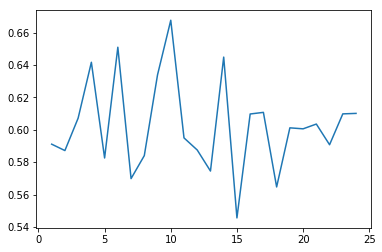

best validatation accu epoch:  10, acc: 0.66773, mean loss: 0.58809 



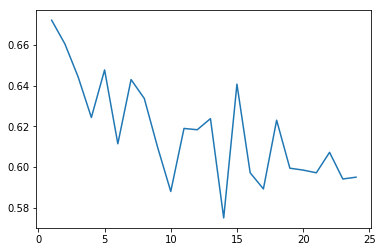

best validatation loss epoch:  14, acc: 0.64495, mean loss: 0.57512


In [12]:
trainLoop(epochs=1000, lr=0.1, wd=1e-6, print_batch_p=0.33, early_patience=10)

Train epoch   1 ( 33%), Mean Accuracy: 0.50339, Mean Loss: 0.69603
Train epoch   1 ( 66%), Mean Accuracy: 0.50710, Mean Loss: 0.69492
Train epoch   1 ( 99%), Mean Accuracy: 0.50983, Mean Loss: 0.69419
Validation epoch   1 (100%), Accucary: 0.35390, Mean Loss: 0.70884 

Train epoch   2 ( 33%), Mean Accuracy: 0.52105, Mean Loss: 0.69200
Train epoch   2 ( 66%), Mean Accuracy: 0.52076, Mean Loss: 0.69184
Train epoch   2 ( 99%), Mean Accuracy: 0.52138, Mean Loss: 0.69172
Validation epoch   2 (100%), Accucary: 0.47486, Mean Loss: 0.69554 

Train epoch   3 ( 33%), Mean Accuracy: 0.52482, Mean Loss: 0.69111
Train epoch   3 ( 66%), Mean Accuracy: 0.52616, Mean Loss: 0.69086
Train epoch   3 ( 99%), Mean Accuracy: 0.52672, Mean Loss: 0.69080
Validation epoch   3 (100%), Accucary: 0.49448, Mean Loss: 0.69441 

Train epoch   4 ( 33%), Mean Accuracy: 0.52756, Mean Loss: 0.69065
Train epoch   4 ( 66%), Mean Accuracy: 0.53022, Mean Loss: 0.69027
Train epoch   4 ( 99%), Mean Accuracy: 0.53025, Mean Los

Train epoch  31 ( 66%), Mean Accuracy: 0.59043, Mean Loss: 0.66644
Train epoch  31 ( 99%), Mean Accuracy: 0.59197, Mean Loss: 0.66575
Validation epoch  31 (100%), Accucary: 0.63707, Mean Loss: 0.62244 

Train epoch  32 ( 33%), Mean Accuracy: 0.59336, Mean Loss: 0.66459
Train epoch  32 ( 66%), Mean Accuracy: 0.59333, Mean Loss: 0.66481
Train epoch  32 ( 99%), Mean Accuracy: 0.59276, Mean Loss: 0.66512
Validation epoch  32 (100%), Accucary: 0.61868, Mean Loss: 0.62984 

Train epoch  33 ( 33%), Mean Accuracy: 0.59575, Mean Loss: 0.66387
Train epoch  33 ( 66%), Mean Accuracy: 0.59354, Mean Loss: 0.66528
Train epoch  33 ( 99%), Mean Accuracy: 0.59375, Mean Loss: 0.66533
Validation epoch  33 (100%), Accucary: 0.60885, Mean Loss: 0.63483 

Train epoch  34 ( 33%), Mean Accuracy: 0.59693, Mean Loss: 0.66377
Train epoch  34 ( 66%), Mean Accuracy: 0.59583, Mean Loss: 0.66450
Train epoch  34 ( 99%), Mean Accuracy: 0.59591, Mean Loss: 0.66430
Validation epoch  34 (100%), Accucary: 0.63239, Mean Los

Train epoch  61 ( 99%), Mean Accuracy: 0.61433, Mean Loss: 0.65302
Validation epoch  61 (100%), Accucary: 0.61065, Mean Loss: 0.62081 

Train epoch  62 ( 33%), Mean Accuracy: 0.61553, Mean Loss: 0.65248
Train epoch  62 ( 66%), Mean Accuracy: 0.61584, Mean Loss: 0.65225
Train epoch  62 ( 99%), Mean Accuracy: 0.61580, Mean Loss: 0.65233
Validation epoch  62 (100%), Accucary: 0.62612, Mean Loss: 0.61104 

Train epoch  63 ( 33%), Mean Accuracy: 0.61721, Mean Loss: 0.65125
Train epoch  63 ( 66%), Mean Accuracy: 0.61594, Mean Loss: 0.65232
Train epoch  63 ( 99%), Mean Accuracy: 0.61560, Mean Loss: 0.65257
Validation epoch  63 (100%), Accucary: 0.64780, Mean Loss: 0.59989 

Train epoch  64 ( 33%), Mean Accuracy: 0.62003, Mean Loss: 0.65012
Train epoch  64 ( 66%), Mean Accuracy: 0.61909, Mean Loss: 0.65082
Train epoch  64 ( 99%), Mean Accuracy: 0.61711, Mean Loss: 0.65181
Validation epoch  64 (100%), Accucary: 0.63875, Mean Loss: 0.60497 

Train epoch  65 ( 33%), Mean Accuracy: 0.61623, Mean L

Train epoch  92 ( 33%), Mean Accuracy: 0.64292, Mean Loss: 0.63175
Train epoch  92 ( 66%), Mean Accuracy: 0.64260, Mean Loss: 0.63208
Train epoch  92 ( 99%), Mean Accuracy: 0.64231, Mean Loss: 0.63205
Validation epoch  92 (100%), Accucary: 0.63924, Mean Loss: 0.59069 

Train epoch  93 ( 33%), Mean Accuracy: 0.64312, Mean Loss: 0.63098
Train epoch  93 ( 66%), Mean Accuracy: 0.64392, Mean Loss: 0.63015
Train epoch  93 ( 99%), Mean Accuracy: 0.64331, Mean Loss: 0.63081
Validation epoch  93 (100%), Accucary: 0.65746, Mean Loss: 0.57723 

Train epoch  94 ( 33%), Mean Accuracy: 0.64249, Mean Loss: 0.63062
Train epoch  94 ( 66%), Mean Accuracy: 0.64294, Mean Loss: 0.63036
Train epoch  94 ( 99%), Mean Accuracy: 0.64419, Mean Loss: 0.62982
Validation epoch  94 (100%), Accucary: 0.64466, Mean Loss: 0.58489 

Train epoch  95 ( 33%), Mean Accuracy: 0.64577, Mean Loss: 0.62920
Train epoch  95 ( 66%), Mean Accuracy: 0.64582, Mean Loss: 0.62878
Train epoch  95 ( 99%), Mean Accuracy: 0.64606, Mean Los

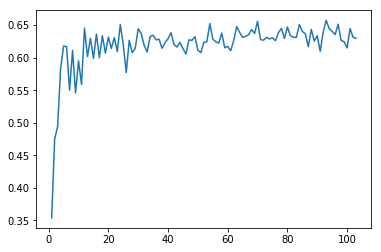

best validatation accu epoch:  93, acc: 0.65746, mean loss: 0.57723 



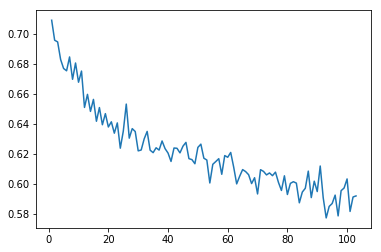

best validatation loss epoch:  93, acc: 0.65746, mean loss: 0.57723


In [13]:
trainLoop(epochs=1000, lr=0.01, wd=1e-6, print_batch_p=0.33, early_patience=10)

Train epoch   1 ( 33%), Mean Accuracy: 0.50397, Mean Loss: 0.69738
Train epoch   1 ( 66%), Mean Accuracy: 0.50363, Mean Loss: 0.69735
Train epoch   1 ( 99%), Mean Accuracy: 0.50423, Mean Loss: 0.69691
Validation epoch   1 (100%), Accucary: 0.48747, Mean Loss: 0.69573 

Train epoch   2 ( 33%), Mean Accuracy: 0.50555, Mean Loss: 0.69618
Train epoch   2 ( 66%), Mean Accuracy: 0.50583, Mean Loss: 0.69587
Train epoch   2 ( 99%), Mean Accuracy: 0.50648, Mean Loss: 0.69561
Validation epoch   2 (100%), Accucary: 0.48706, Mean Loss: 0.69551 

Train epoch   3 ( 33%), Mean Accuracy: 0.50762, Mean Loss: 0.69504
Train epoch   3 ( 66%), Mean Accuracy: 0.50791, Mean Loss: 0.69480
Train epoch   3 ( 99%), Mean Accuracy: 0.50962, Mean Loss: 0.69450
Validation epoch   3 (100%), Accucary: 0.46708, Mean Loss: 0.69785 

Train epoch   4 ( 33%), Mean Accuracy: 0.50857, Mean Loss: 0.69459
Train epoch   4 ( 66%), Mean Accuracy: 0.51020, Mean Loss: 0.69424
Train epoch   4 ( 99%), Mean Accuracy: 0.51155, Mean Los

Train epoch  31 ( 66%), Mean Accuracy: 0.53223, Mean Loss: 0.68980
Train epoch  31 ( 99%), Mean Accuracy: 0.53353, Mean Loss: 0.68960
Validation epoch  31 (100%), Accucary: 0.58243, Mean Loss: 0.68304 

Train epoch  32 ( 33%), Mean Accuracy: 0.53338, Mean Loss: 0.68966
Train epoch  32 ( 66%), Mean Accuracy: 0.53183, Mean Loss: 0.68989
Train epoch  32 ( 99%), Mean Accuracy: 0.53246, Mean Loss: 0.68977
Validation epoch  32 (100%), Accucary: 0.58490, Mean Loss: 0.68258 

Train epoch  33 ( 33%), Mean Accuracy: 0.53284, Mean Loss: 0.68943
Train epoch  33 ( 66%), Mean Accuracy: 0.53350, Mean Loss: 0.68943
Train epoch  33 ( 99%), Mean Accuracy: 0.53247, Mean Loss: 0.68958
Validation epoch  33 (100%), Accucary: 0.55989, Mean Loss: 0.68555 

Train epoch  34 ( 33%), Mean Accuracy: 0.53182, Mean Loss: 0.68973
Train epoch  34 ( 66%), Mean Accuracy: 0.53269, Mean Loss: 0.68939
Train epoch  34 ( 99%), Mean Accuracy: 0.53230, Mean Loss: 0.68943
Validation epoch  34 (100%), Accucary: 0.55855, Mean Los


Train epoch  62 ( 33%), Mean Accuracy: 0.54518, Mean Loss: 0.68611
Train epoch  62 ( 66%), Mean Accuracy: 0.54745, Mean Loss: 0.68579
Train epoch  62 ( 99%), Mean Accuracy: 0.54713, Mean Loss: 0.68592
Validation epoch  62 (100%), Accucary: 0.57429, Mean Loss: 0.67965 

Train epoch  63 ( 33%), Mean Accuracy: 0.54309, Mean Loss: 0.68660
Train epoch  63 ( 66%), Mean Accuracy: 0.54473, Mean Loss: 0.68655
Train epoch  63 ( 99%), Mean Accuracy: 0.54467, Mean Loss: 0.68634
Validation epoch  63 (100%), Accucary: 0.57729, Mean Loss: 0.67885 

Train epoch  64 ( 33%), Mean Accuracy: 0.54878, Mean Loss: 0.68536
Train epoch  64 ( 66%), Mean Accuracy: 0.54686, Mean Loss: 0.68565
Train epoch  64 ( 99%), Mean Accuracy: 0.54700, Mean Loss: 0.68584
Validation epoch  64 (100%), Accucary: 0.59258, Mean Loss: 0.67590 

Train epoch  65 ( 33%), Mean Accuracy: 0.54311, Mean Loss: 0.68642
Train epoch  65 ( 66%), Mean Accuracy: 0.54531, Mean Loss: 0.68607
Train epoch  65 ( 99%), Mean Accuracy: 0.54559, Mean Lo


Train epoch  93 ( 33%), Mean Accuracy: 0.55592, Mean Loss: 0.68213
Train epoch  93 ( 66%), Mean Accuracy: 0.55860, Mean Loss: 0.68159
Train epoch  93 ( 99%), Mean Accuracy: 0.55717, Mean Loss: 0.68191
Validation epoch  93 (100%), Accucary: 0.58565, Mean Loss: 0.66806 

Train epoch  94 ( 33%), Mean Accuracy: 0.56055, Mean Loss: 0.68161
Train epoch  94 ( 66%), Mean Accuracy: 0.55902, Mean Loss: 0.68177
Train epoch  94 ( 99%), Mean Accuracy: 0.55879, Mean Loss: 0.68185
Validation epoch  94 (100%), Accucary: 0.58826, Mean Loss: 0.66699 

Train epoch  95 ( 33%), Mean Accuracy: 0.56211, Mean Loss: 0.68138
Train epoch  95 ( 66%), Mean Accuracy: 0.55826, Mean Loss: 0.68202
Train epoch  95 ( 99%), Mean Accuracy: 0.55830, Mean Loss: 0.68210
Validation epoch  95 (100%), Accucary: 0.58573, Mean Loss: 0.66726 

Train epoch  96 ( 33%), Mean Accuracy: 0.56031, Mean Loss: 0.68103
Train epoch  96 ( 66%), Mean Accuracy: 0.55940, Mean Loss: 0.68137
Train epoch  96 ( 99%), Mean Accuracy: 0.55835, Mean Lo

Train epoch 123 ( 66%), Mean Accuracy: 0.56929, Mean Loss: 0.67745
Train epoch 123 ( 99%), Mean Accuracy: 0.56851, Mean Loss: 0.67765
Validation epoch 123 (100%), Accucary: 0.59765, Mean Loss: 0.65719 

Train epoch 124 ( 33%), Mean Accuracy: 0.56703, Mean Loss: 0.67792
Train epoch 124 ( 66%), Mean Accuracy: 0.56862, Mean Loss: 0.67755
Train epoch 124 ( 99%), Mean Accuracy: 0.56877, Mean Loss: 0.67768
Validation epoch 124 (100%), Accucary: 0.60373, Mean Loss: 0.65534 

Train epoch 125 ( 33%), Mean Accuracy: 0.56724, Mean Loss: 0.67818
Train epoch 125 ( 66%), Mean Accuracy: 0.56827, Mean Loss: 0.67757
Train epoch 125 ( 99%), Mean Accuracy: 0.56912, Mean Loss: 0.67733
Validation epoch 125 (100%), Accucary: 0.60434, Mean Loss: 0.65485 

Train epoch 126 ( 33%), Mean Accuracy: 0.57173, Mean Loss: 0.67663
Train epoch 126 ( 66%), Mean Accuracy: 0.57034, Mean Loss: 0.67703
Train epoch 126 ( 99%), Mean Accuracy: 0.57022, Mean Loss: 0.67686
Validation epoch 126 (100%), Accucary: 0.60324, Mean Los

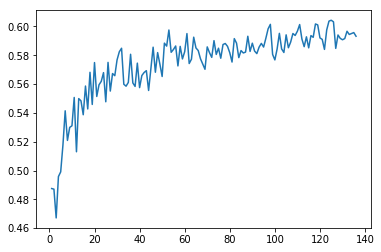

best validatation accu epoch: 125, acc: 0.60434, mean loss: 0.65485 



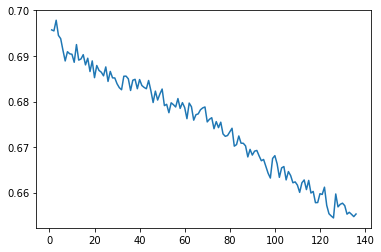

best validatation loss epoch: 126, acc: 0.60324, mean loss: 0.65443


In [14]:
trainLoop(epochs=1000, lr=0.001, wd=1e-6, print_batch_p=0.33, early_patience=10)